In [1]:
import findspark
findspark.init('/home/ubuntu/spark-3.2.1-bin-hadoop2.7')
import pyspark
import pandas as pd
import numpy as np

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, isnan, when
# 初始化Spark会话
spark = SparkSession.builder \
    .appName('722') \
    .config('spark.sql.debug.maxToStringFields', '1000') \
    .getOrCreate()


Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/05/23 05:42:22 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


2.2 Describe the data

In [2]:
# 加载CSV数据
hospital = spark.read.format("csv").option("header", "true").option("inferSchema", "true").load("hospital distribution.csv")
clients_data = spark.read.format("csv").option("header", "true").option("inferSchema", "true").load("clients.csv")
education = spark.read.format("csv").option("header", "true").option("inferSchema", "true").load("Education.csv")
income = spark.read.format("csv").option("header", "true").option("inferSchema", "true").load("Income dataset.csv")
life = spark.read.format("csv").option("header", "true").option("inferSchema", "true").load("life expectancy.csv")

In [3]:
# 描述数据集的函数
def describe_data(df, name):
    print(f"Dataset Name: {name}")
    print(f"Format: CSV")
    print(f"Number of Rows: {df.count()}")
    print(f"Number of Columns: {len(df.columns)}")
    print("\nFields and Data Types:")
    df.printSchema()
    print("\nSample Data:")
    df.show(5)
    print("\nMissing Values (%):")
    missing_values = df.select([(count(when(col(c).isNull() | isnan(c), c)) / df.count() * 100).alias(c) for c in df.columns])
    missing_values.show()
    print("\n")


In [4]:
# 调用函数描述每个数据集
describe_data(hospital, "Hospital Distribution")

Dataset Name: Hospital Distribution
Format: CSV
Number of Rows: 71
Number of Columns: 28

Fields and Data Types:
root
 |-- Premises_Name: string (nullable = true)
 |-- Certification_Service_Type: string (nullable = true)
 |-- Service_Types: string (nullable = true)
 |-- Total_Beds: integer (nullable = true)
 |-- Premises_Website: string (nullable = true)
 |-- Premises_Address_Other: string (nullable = true)
 |-- Premises_Address: string (nullable = true)
 |-- Premises_Address_Suburb_Road: string (nullable = true)
 |-- City: string (nullable = true)
 |-- Premises_Address_Post_Code: integer (nullable = true)
 |-- DHB_Name: string (nullable = true)
 |-- Certificate_Name: string (nullable = true)
 |-- Certification_Period__Months_: string (nullable = true)
 |-- Certificate_License_End_Date: string (nullable = true)
 |-- Current_Auditor: string (nullable = true)
 |-- Legal_Name: string (nullable = true)
 |-- Legal_Entity_Address_Other: string (nullable = true)
 |-- Legal_Entity_Address: str

In [5]:
# 检测Total_Beds字段中的异常值
if 'Total_Beds' in hospital.columns:
    Q1 = hospital.approxQuantile("Total_Beds", [0.25], 0.0)[0]
    Q3 = hospital.approxQuantile("Total_Beds", [0.75], 0.0)[0]
    IQR = Q3 - Q1
    outliers = hospital.filter((col("Total_Beds") < (Q1 - 1.5 * IQR)) | (col("Total_Beds") > (Q3 + 1.5 * IQR)))
    total_beds_outliers_percentage = outliers.count() / hospital.count() * 100
else:
    outliers = None
    total_beds_outliers_percentage = None

print(f"Percentage of outliers in Total_Beds: {total_beds_outliers_percentage}%")
if outliers is not None:
    outliers.show()

describe_data(clients_data, "Clients Data")

Percentage of outliers in Total_Beds: 12.676056338028168%
+--------------------+--------------------------+--------------------+----------+----------------+----------------------+--------------------+----------------------------+------------+--------------------------+--------------------+--------------------+-----------------------------+----------------------------+--------------------+--------------------+--------------------------+--------------------+-------------------------------+------------------------------+------------------------------+---------------------------+-------------------------------+-------------------------------+-------------------------------+--------------------+--------+-------------+
|       Premises_Name|Certification_Service_Type|       Service_Types|Total_Beds|Premises_Website|Premises_Address_Other|    Premises_Address|Premises_Address_Suburb_Road|        City|Premises_Address_Post_Code|            DHB_Name|    Certificate_Name|Certification_Period__Mo

+-----+-------------+-----------+------+----+---+
|count|       Region|destination|amount|year|Key|
+-----+-------------+-----------+------+----+---+
|    1|    Northland|  Northland|  5978|2015|  1|
|    3|     Auckland|  Northland|   132|2015|  1|
|    5|      Waikato|  Northland|    75|2015|  1|
|    7|Bay of Plenty|  Northland|    36|2015|  1|
|    9|     Taranaki|  Northland|    15|2015|  1|
+-----+-------------+-----------+------+----+---+
only showing top 5 rows


Missing Values (%):
+-----+------+-----------+-----------------+------------------+------------------+
|count|Region|destination|           amount|              year|               Key|
+-----+------+-----------+-----------------+------------------+------------------+
|  0.0|   0.0|        0.0|5.737704918032787|11.475409836065573|11.475409836065573|
+-----+------+-----------+-----------------+------------------+------------------+





In [6]:
# 检测clients_data中amount字段的异常值
if 'amount' in clients_data.columns:
    Q1 = clients_data.approxQuantile("amount", [0.25], 0.0)[0]
    Q3 = clients_data.approxQuantile("amount", [0.75], 0.0)[0]
    IQR = Q3 - Q1
    outliers = clients_data.filter((col("amount") < (Q1 - 1.5 * IQR)) | (col("amount") > (Q3 + 1.5 * IQR)))
    amount_outliers_percentage = outliers.count() / clients_data.count() * 100
else:
    outliers = None
    amount_outliers_percentage = None

print(f"Percentage of outliers in amount: {amount_outliers_percentage}%")
if outliers is not None:
    outliers.show()

describe_data(education, "Education Data")
describe_data(income, "Income Data")
describe_data(life, "Life Expectancy Data")

Percentage of outliers in amount: 14.262295081967213%
+-----+-------------+----------------+------+----+---+
|count|       Region|     destination|amount|year|Key|
+-----+-------------+----------------+------+----+---+
|    1|    Northland|       Northland|  5978|2015|  1|
|    3|     Auckland|       Northland|   132|2015|  1|
|   23|    Northland|       Waitemata|   745|2015|  1|
|   25|     Auckland|       Waitemata|  6177|2015|  1|
|   27|      Waikato|       Waitemata|   639|2015|  1|
|   29|Bay of Plenty|       Waitemata|   198|2015|  1|
|   40|   Canterbury|       Waitemata|   130|2015|  1|
|   45|    Northland|        Auckland|   145|2015|  1|
|   47|     Auckland|        Auckland| 10079|2015|  1|
|   49|      Waikato|        Auckland|   221|2015|  1|
|   51|Bay of Plenty|        Auckland|   116|2015|  1|
|   67|    Northland|Counties Manukau|   147|2015|  1|
|   69|     Auckland|Counties Manukau|  1213|2015|  1|
|   71|      Waikato|Counties Manukau|   192|2015|  1|
|   91|    

+----+------+------------------------------+------------------------------+----------------------------------+-----------------------------------------+-----------------------------+-----------------------------+---------------------------------+----------------------------------------+--------------------------+
|Year|Region|Average Wage and Salary Income|Average Self-employment Income|Average Government Transfer Income|Average Income from All Sources collected|Median Wage and Salary Income|Median Self-employment Income|Median Government Transfer Income|Median Income from All Sources collected|Number of households (000)|
+----+------+------------------------------+------------------------------+----------------------------------+-----------------------------------------+-----------------------------+-----------------------------+---------------------------------+----------------------------------------+--------------------------+
| 0.0|   0.0|                           0.0|           

2.3 Explore the data

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [8]:
clients_pd = clients_data.toPandas()

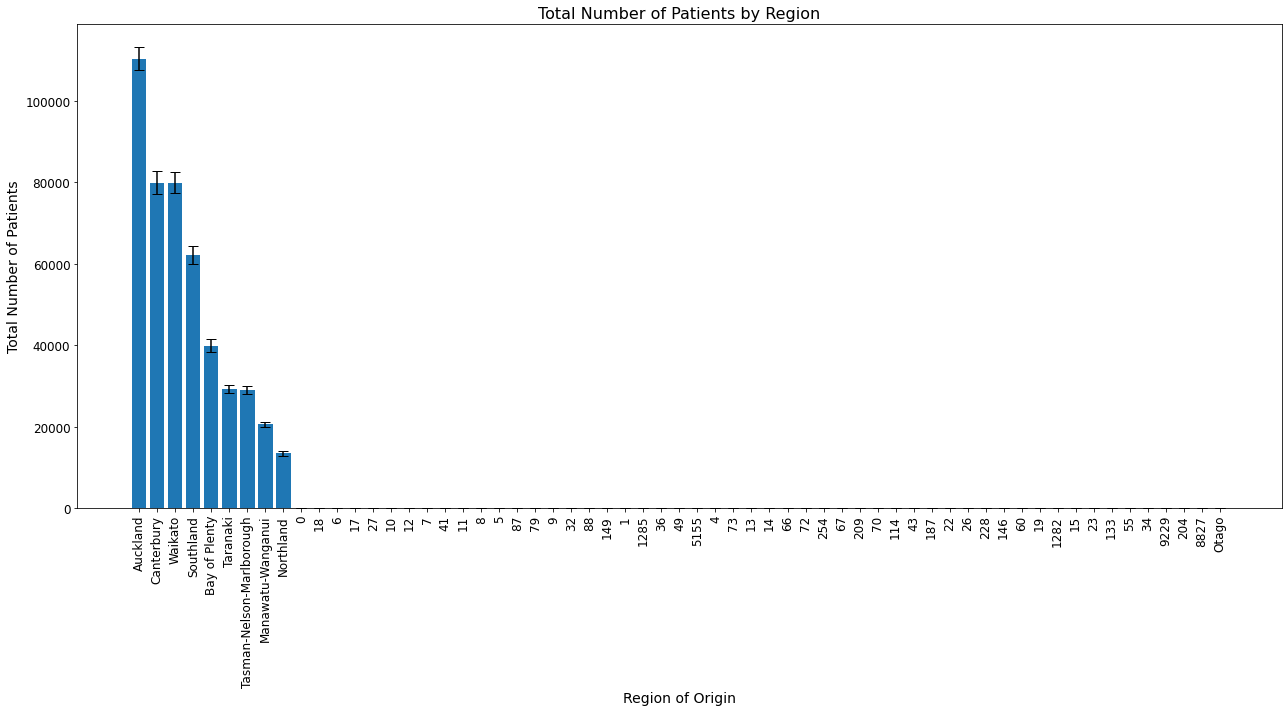

In [9]:
from pyspark.sql.functions import col, sum as _sum, mean as _mean, stddev as _stddev
import matplotlib.pyplot as plt

# Fill any missing values in 'amount' with zero
clients_data = clients_data.na.fill(0, subset=['amount'])

# Group by region and aggregate the total number of patients
region_data = clients_data.groupBy('Region').agg(
    _sum('amount').alias('Total_Patients'),
    _mean('amount').alias('Mean_Patients'),
    _stddev('amount').alias('Std_Dev_Patients')
)

# Convert to Pandas DataFrame for plotting
region_data_pd = region_data.toPandas()

# Replace NaN values in the resulting Pandas DataFrame with zero
region_data_pd = region_data_pd.fillna(0)

# Sort the data by total number of patients for better visualization
region_data_pd = region_data_pd.sort_values('Total_Patients', ascending=False)

# Plot the bar chart with correct region names
plt.figure(figsize=(18, 10))
bars = plt.bar(region_data_pd['Region'], region_data_pd['Total_Patients'], yerr=region_data_pd['Std_Dev_Patients'], capsize=5)
plt.xlabel('Region of Origin', fontsize=14)
plt.ylabel('Total Number of Patients', fontsize=14)
plt.title('Total Number of Patients by Region', fontsize=16)
plt.xticks(rotation=90, fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

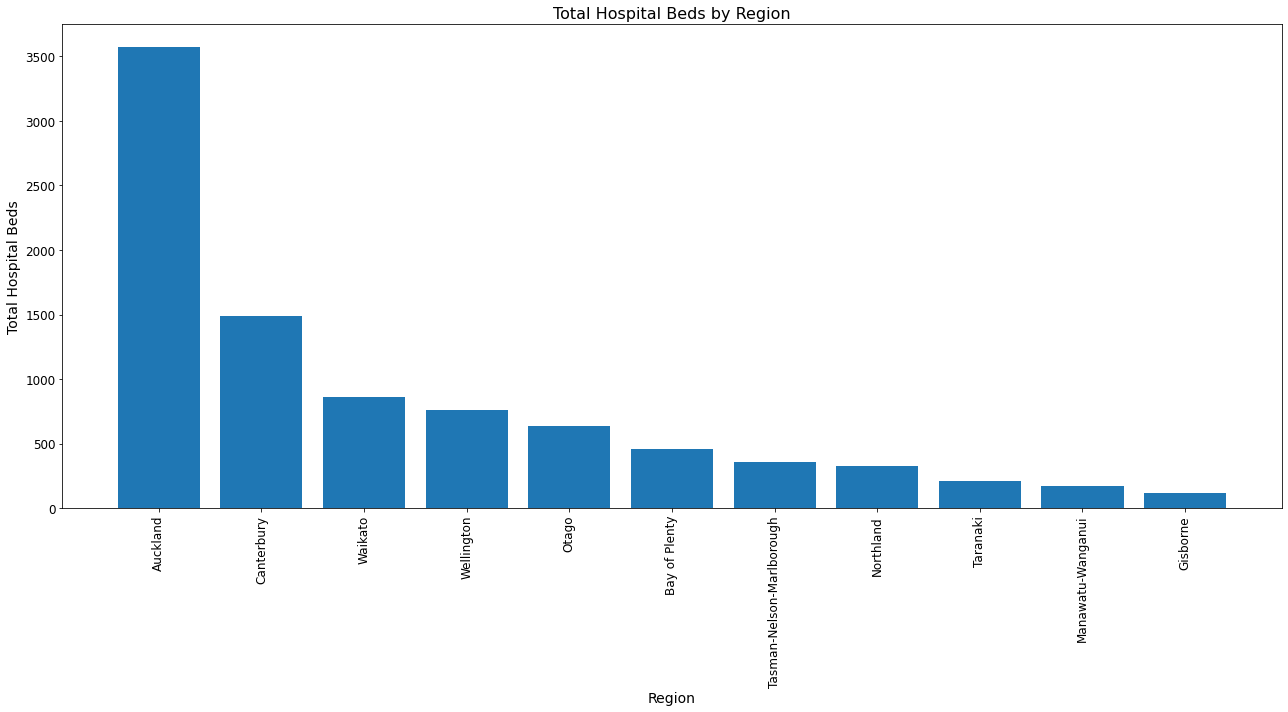

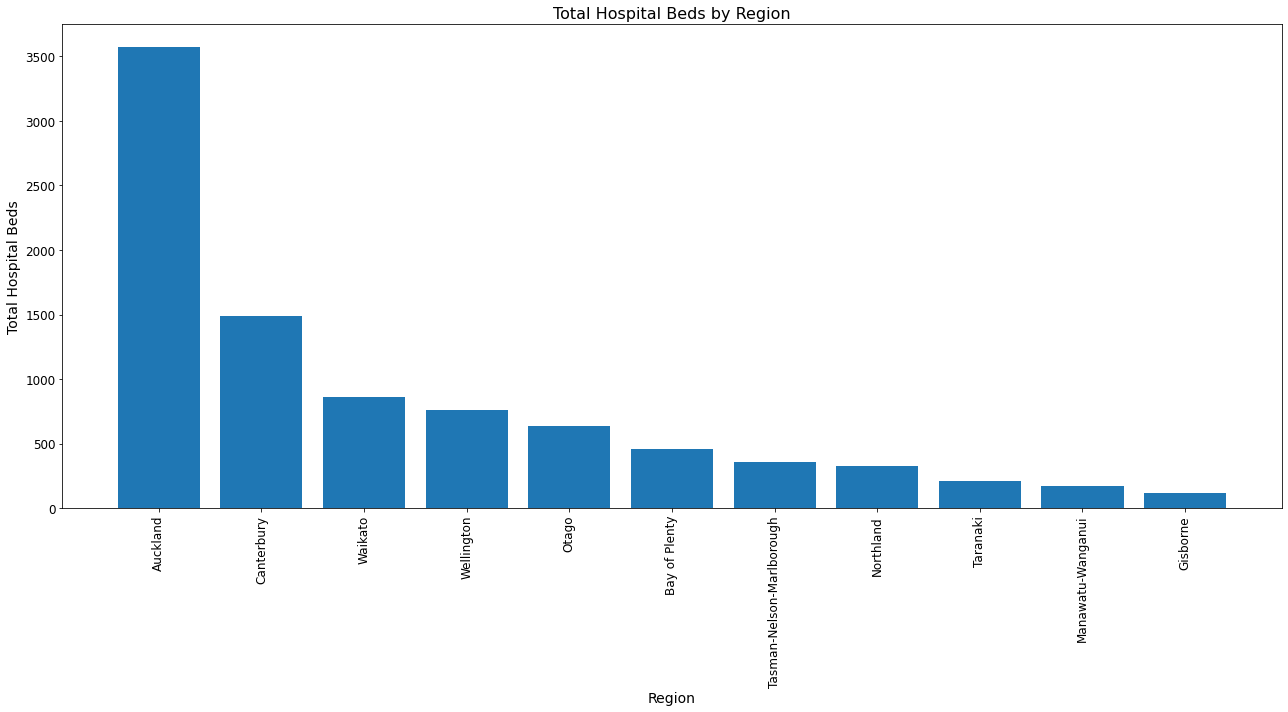

In [10]:
import matplotlib.pyplot as plt
from pyspark.sql.functions import col, sum as _sum

# Fill any missing values in 'Total_Beds' with zero
hospital = hospital.na.fill(0, subset=['Total_Beds'])

# Group by region and aggregate the total number of beds
region_beds_data = hospital.groupBy('Region').agg(
    _sum('Total_Beds').alias('Total_Beds')
)

# Convert to Pandas DataFrame for plotting
region_beds_data_pd = region_beds_data.toPandas()

# Sort the data by total number of beds for better visualization
region_beds_data_pd = region_beds_data_pd.sort_values('Total_Beds', ascending=False)

# Plot the bar chart with correct region names
plt.figure(figsize=(18, 10))
bars = plt.bar(region_beds_data_pd['Region'], region_beds_data_pd['Total_Beds'])
plt.xlabel('Region', fontsize=14)
plt.ylabel('Total Hospital Beds', fontsize=14)
plt.title('Total Hospital Beds by Region', fontsize=16)
plt.xticks(rotation=90, fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()
import matplotlib.pyplot as plt
from pyspark.sql.functions import col, sum as _sum

# Load the CSV data for hospital distribution
hospital = spark.read.format("csv").option("header", "true").option("inferSchema", "true").load("hospital distribution.csv")

# Fill any missing values in 'Total_Beds' with zero
hospital = hospital.na.fill(0, subset=['Total_Beds'])

# Group by region and aggregate the total number of beds
region_beds_data = hospital.groupBy('Region').agg(
    _sum('Total_Beds').alias('Total_Beds')
)

# Convert to Pandas DataFrame for plotting
region_beds_data_pd = region_beds_data.toPandas()

# Sort the data by total number of beds for better visualization
region_beds_data_pd = region_beds_data_pd.sort_values('Total_Beds', ascending=False)

# Plot the bar chart with correct region names
plt.figure(figsize=(18, 10))
bars = plt.bar(region_beds_data_pd['Region'], region_beds_data_pd['Total_Beds'])
plt.xlabel('Region', fontsize=14)
plt.ylabel('Total Hospital Beds', fontsize=14)
plt.title('Total Hospital Beds by Region', fontsize=16)
plt.xticks(rotation=90, fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()


<Figure size 1296x720 with 0 Axes>

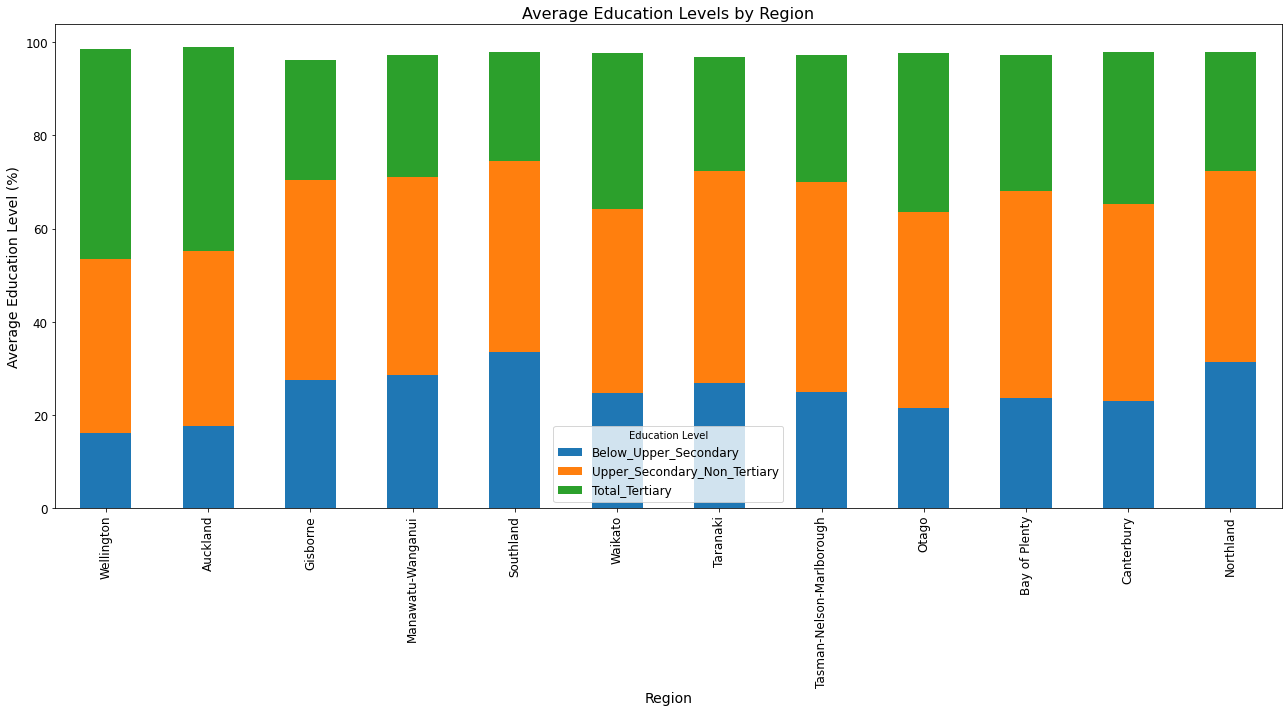

In [12]:
# Group by region and aggregate the average education levels
education = spark.read.format("csv").option("header", "true").option("inferSchema", "true").load("Education.csv")
region_education_data = education.groupBy('Region').agg(
    _mean('Below upper secondary education').alias('Below_Upper_Secondary'),
    _mean('Upper secondary and post-secondary non-tertiary education').alias('Upper_Secondary_Non_Tertiary'),
    _mean('Total tertiary education (ISCED2011 levels 5 to 8)').alias('Total_Tertiary')
)

# Convert to Pandas DataFrame for plotting
region_education_data_pd = region_education_data.toPandas()

# Plot the bar chart for different education levels by region
plt.figure(figsize=(18, 10))
region_education_data_pd.plot(kind='bar', x='Region', stacked=True, figsize=(18, 10))
plt.xlabel('Region', fontsize=14)
plt.ylabel('Average Education Level (%)', fontsize=14)
plt.title('Average Education Levels by Region', fontsize=16)
plt.xticks(rotation=90, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='Education Level', fontsize=12)
plt.tight_layout()
plt.show()



<Figure size 1296x720 with 0 Axes>

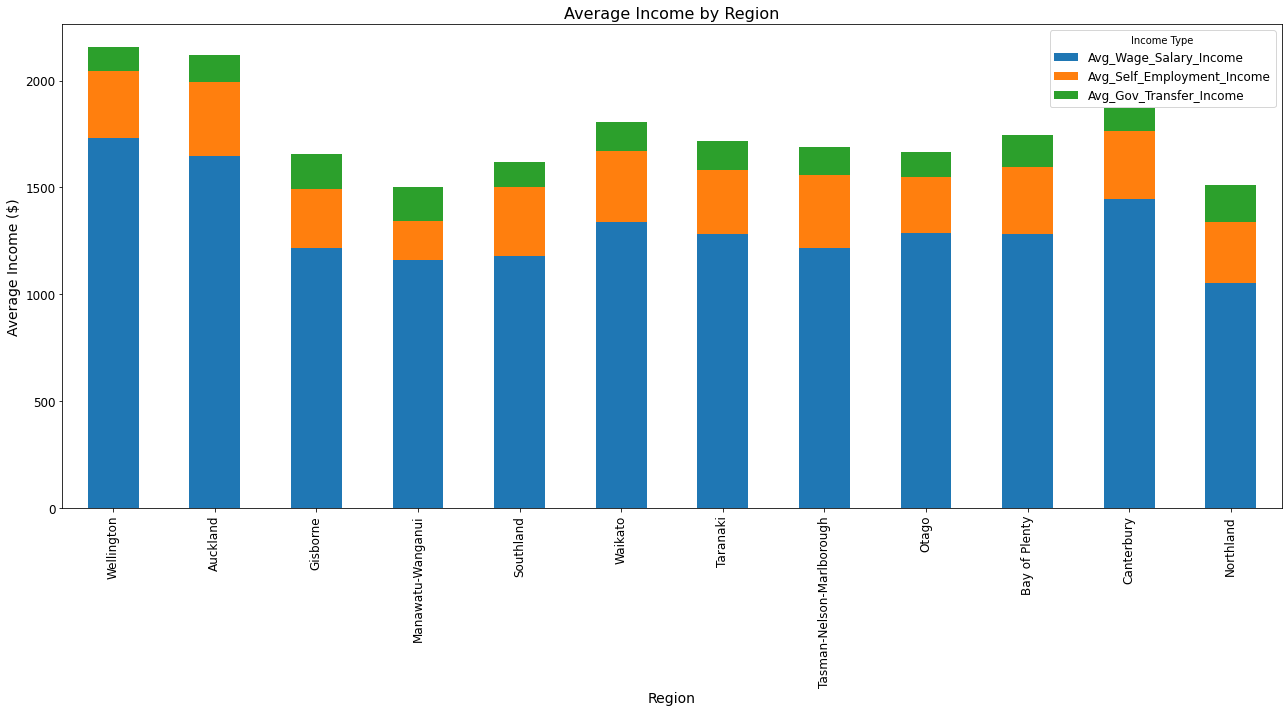

In [13]:
# Group by region and aggregate the average income
income = spark.read.format("csv").option("header", "true").option("inferSchema", "true").load("Income dataset.csv")
region_income_data = income.groupBy('Region').agg(
    _mean('Average Wage and Salary Income').alias('Avg_Wage_Salary_Income'),
    _mean('Average Self-employment Income').alias('Avg_Self_Employment_Income'),
    _mean('Average Government Transfer Income').alias('Avg_Gov_Transfer_Income')
)

# Convert to Pandas DataFrame for plotting
region_income_data_pd = region_income_data.toPandas()

# Plot the bar chart for average income by region
plt.figure(figsize=(18, 10))
region_income_data_pd.plot(kind='bar', x='Region', stacked=True, figsize=(18, 10))
plt.xlabel('Region', fontsize=14)
plt.ylabel('Average Income ($)', fontsize=14)
plt.title('Average Income by Region', fontsize=16)
plt.xticks(rotation=90, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='Income Type', fontsize=12)
plt.tight_layout()
plt.show()


<Figure size 1296x720 with 0 Axes>

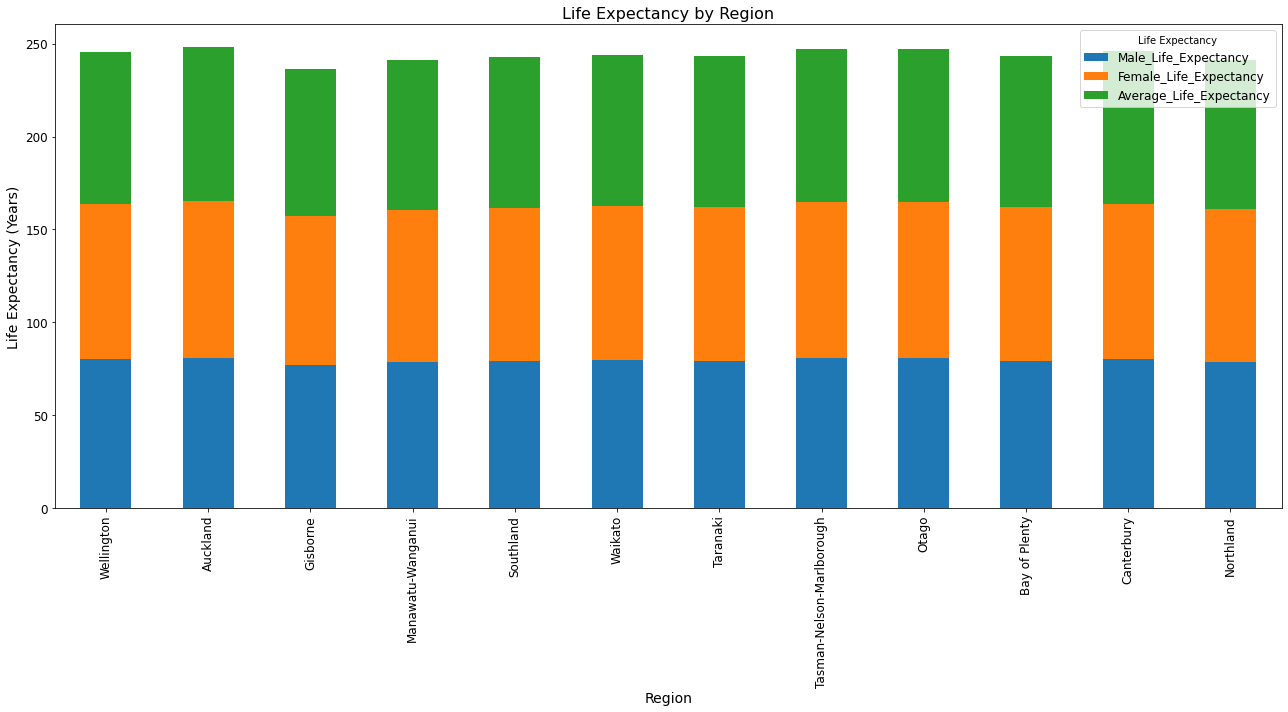

In [14]:
# Group by region and get the average life expectancy
life = spark.read.format("csv").option("header", "true").option("inferSchema", "true").load("life expectancy.csv")
region_life_data = life.groupBy('Region').agg(
    _mean('Male').alias('Male_Life_Expectancy'),
    _mean('Female').alias('Female_Life_Expectancy'),
    _mean('Average').alias('Average_Life_Expectancy')
)

# Convert to Pandas DataFrame for plotting
region_life_data_pd = region_life_data.toPandas()

# Plot the bar chart for life expectancy by region
plt.figure(figsize=(18, 10))
region_life_data_pd.plot(kind='bar', x='Region', stacked=True, figsize=(18, 10))
plt.xlabel('Region', fontsize=14)
plt.ylabel('Life Expectancy (Years)', fontsize=14)
plt.title('Life Expectancy by Region', fontsize=16)
plt.xticks(rotation=90, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='Life Expectancy', fontsize=12)
plt.tight_layout()
plt.show()


2.4 Data Quality Verification

In [15]:
# Import necessary libraries
import pandas as pd

# Convert Spark DataFrames to Pandas DataFrames for analysis
clients_data_pd = clients_data.toPandas()
hospital_pd = hospital.toPandas()

# Generate a statistical summary of the 'amount' column
summary = clients_data_pd['amount'].describe()

# Print the statistical summary
print("Statistical Summary of 'amount' column:")
print(summary)

# Calculate skewness and kurtosis
skewness = clients_data_pd['amount'].skew()
kurtosis = clients_data_pd['amount'].kurt()

print(f"\nSkewness: {skewness}")
print(f"Kurtosis: {kurtosis}")

# Check for missing values in the 'clients_data' DataFrame
missing_values_clients = clients_data_pd.isnull().mean() * 100
print("\nMissing values in 'clients_data':")
print(missing_values_clients)

# Print the data types of each column in the hospital DataFrame
print("\nData types before conversion:")
print(hospital_pd.dtypes)

# Convert columns to appropriate data types
hospital_pd['Certificate_License_End_Date'] = pd.to_datetime(hospital_pd['Certificate_License_End_Date'], format='%d-%m-%Y', errors='coerce')
hospital_pd['Certification_Period__Months_'] = pd.to_numeric(hospital_pd['Certification_Period__Months_'], errors='coerce')
hospital_pd['Legal_Entity_Address_Suburb_Roa'] = hospital_pd['Legal_Entity_Address_Suburb_Roa'].astype('object')

# Print the data types of each column after conversion
print("\nData types after conversion:")
print(hospital_pd.dtypes)

# Check for missing values in the 'hospital' DataFrame
missing_values_hospital = hospital_pd.isnull().mean() * 100
print("\nMissing values in 'hospital' DataFrame:")
print(missing_values_hospital)

# Verify the data quality for the 'education' dataset
education_pd = education.toPandas()
missing_values_education = education_pd.isnull().mean() * 100
print("\nMissing values in 'education' DataFrame:")
print(missing_values_education)

# Verify the data quality for the 'income' dataset
income_pd = income.toPandas()
missing_values_income = income_pd.isnull().mean() * 100
print("\nMissing values in 'income' DataFrame:")
print(missing_values_income)

# Verify the data quality for the 'life expectancy' dataset
life_pd = life.toPandas()
missing_values_life = life_pd.isnull().mean() * 100
print("\nMissing values in 'life expectancy' DataFrame:")
print(missing_values_life)


Statistical Summary of 'amount' column:
count     1150.000000
mean       404.046957
std       1797.047113
min          0.000000
25%          3.000000
50%         14.000000
75%         47.000000
max      13821.000000
Name: amount, dtype: float64

Skewness: 5.3701590758474635
Kurtosis: 29.12869869950505

Missing values in 'clients_data':
count           0.000000
Region          0.000000
destination     0.000000
amount          5.737705
year           11.475410
Key            11.475410
dtype: float64

Data types before conversion:
Premises_Name                      object
Certification_Service_Type         object
Service_Types                      object
Total_Beds                          int32
Premises_Website                   object
Premises_Address_Other             object
Premises_Address                   object
Premises_Address_Suburb_Road       object
City                               object
Premises_Address_Post_Code          int32
DHB_Name                           object
Cert

3.2 Clean the Data

In [19]:
# Import necessary libraries
import pandas as pd
import numpy as np
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

# Initialize Spark session
spark = SparkSession.builder.appName("DataCleaning").getOrCreate()

# 3.2.1 Handling missing values

# Calculate the completion rate for each row
hospital = hospital.withColumn("completion_rate", sum(col(c).isNotNull().cast("int") for c in hospital.columns) / len(hospital.columns))

# Filter to keep only rows with a completion rate greater than or equal to 0.60
filtered_hospital = hospital.filter(col("completion_rate") >= 0.60)

# Drop the 'completion_rate' column as it's no longer needed
filtered_hospital = filtered_hospital.drop("completion_rate")

# Convert to Pandas DataFrame for further analysis
filtered_hospital_pd = filtered_hospital.toPandas()

# Display the first few rows of the filtered DataFrame
print(filtered_hospital_pd.head())

# Load the education dataset
education_file = 'Education.csv'
education_data = pd.read_csv(education_file, encoding='ISO-8859-1')

# 3.2.2 Imputation function for missing values using random normal distribution
def impute_with_normal_distribution(df, column_name):
    mean = df[column_name].mean()  # Calculate the mean of the column
    std = df[column_name].std()    # Calculate the standard deviation
    missing_count = df[column_name].isnull().sum()  # Count missing values

    # Generate random values based on the mean, std, and count of missing values
    imputation_values = np.random.normal(loc=mean, scale=std, size=missing_count)

    # Fill missing values in the column with the imputed values
    df.loc[df[column_name].isnull(), column_name] = imputation_values
    
    return df

# Apply imputation to the specific column
education_data = impute_with_normal_distribution(education_data, '  Short-cycle tertiary education (ISCED2011 level 5)')

# Validate results by printing a summary of the column statistics
print(education_data['  Short-cycle tertiary education (ISCED2011 level 5)'].describe())


                            Premises_Name Certification_Service_Type  \
0                  Auckland City Hospital            Public Hospital   
1  Auckland DHB X 3 Units - Mental Health            Public Hospital   
2          Buchanan Rehabilitation Centre            Public Hospital   
3               Greenlane Clinical Centre            Public Hospital   
4              Opotiki Health Care Centre            Public Hospital   

                                    Service_Types  Total_Beds  \
0  Childrens health, Maternity, Surgical, Medical        1124   
1                                   Mental health          96   
2                                   Mental health          40   
3                               Surgical, Medical          31   
4                    Maternity, Surgical, Medical           6   

  Premises_Website Premises_Address_Other     Premises_Address  \
0             None                   None          2 Park Road   
1             None                   None   

3.3 Deriving new features

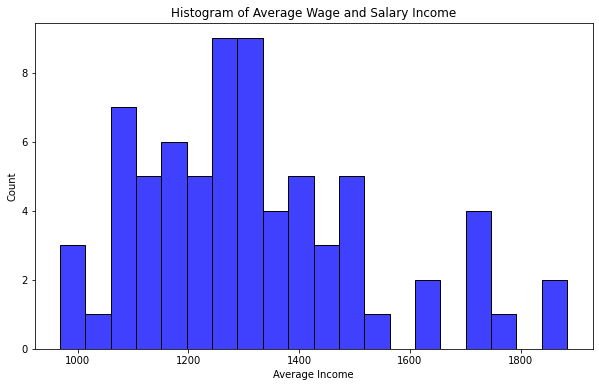

Medium_Salary    38
Low_Salary       22
High_Salary      12
Name: Salary_Tier, dtype: int64


In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession

# Start Spark session
spark = SparkSession.builder.appName("IncomeDataAnalysis").getOrCreate()

# Load CSV data into Spark DataFrame
income_spark = spark.read.format("csv").option("header", "true").option("inferSchema", "true").load("Income dataset.csv")

# Convert to Pandas DataFrame for visualization
income_pd = income_spark.toPandas()

# Generate histogram of average wage and salary income
plt.figure(figsize=(10, 6))  # Set the figure size
sns.histplot(income_pd['Average Wage and Salary Income'], bins=20, kde=False, color='blue')  # Plot histogram with seaborn
plt.title('Histogram of Average Wage and Salary Income')  # Add a title
plt.xlabel('Average Income')  # Label the x-axis
plt.ylabel('Count')  # Label the y-axis
plt.show()  # Display the histogram

# Define bins and labels for the Salary Tier
bins = [0, 1200, 1500, float('inf')]  # Use float('inf') to include all higher incomes in the last bin
labels = ['Low_Salary', 'Medium_Salary', 'High_Salary']

# Categorize salary into defined tiers
income_pd['Salary_Tier'] = pd.cut(income_pd['Average Wage and Salary Income'], bins=bins, labels=labels, right=False)

# Verify the categorization
print(income_pd['Salary_Tier'].value_counts())


3.4 Data Integration

In [3]:

# Merge life expectancy data with income data on 'Region'
merged_data = life.join(income, on='Region', how='inner')

# Merge the result with education data
merged_data = merged_data.join(education, on='Region', how='inner')

# Continue merging with clients data
merged_data = merged_data.join(clients_data, on='Region', how='inner')

# Finally, merge with hospital data
final_merged_data = merged_data.join(hospital, on='Region', how='inner')

# Show the first few rows of the merged dataset
final_merged_data.show()

# Get an overview of the dataset, including non-null counts and data types
final_merged_data.printSchema()
final_merged_data.describe().show()



+---------+----+------+-------+----+------------------------------+------------------------------+----------------------------------+-----------------------------------------+-----------------------------+-----------------------------+---------------------------------+----------------------------------------+--------------------------+-----+-------------------------------+---------------------------------------------------------+--------------------------------------------------+----------------------------------------------------+----------------------------------------------------+--------------------------------------------------+---------------------------------------------------+-----+-----------+------+----+----+--------------------+--------------------------+--------------------+----------+----------------+----------------------+----------------+----------------------------+----------+--------------------------+--------------------+--------------------+--------------------------

+-------+--------+-----------------+------------------+------------------+------------------+------------------------------+------------------------------+----------------------------------+-----------------------------------------+-----------------------------+-----------------------------+---------------------------------+----------------------------------------+--------------------------+------------------+-------------------------------+---------------------------------------------------------+--------------------------------------------------+----------------------------------------------------+----------------------------------------------------+--------------------------------------------------+---------------------------------------------------+-----------------+-----------+-----------------+------------------+------+------------------+--------------------------+--------------------+------------------+----------------+----------------------+----------------+--------------------

3.5

In [24]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

# Start Spark session
spark = SparkSession.builder.appName("DataIntegration").getOrCreate()


# Define roles of variables with accurate column names
variable_roles = {
    'input': [
        'Region', 
        'Average Wage and Salary Income', 
        'Below upper secondary education'
    ],
    'target': [
        'Average'  
    ]
}


# Assign roles in the DataFrame
for role, columns in variable_roles.items():
    for column in columns:
        final_merged_data = final_merged_data.withColumn(column + '_role', col(column))

# Adjust data types
final_merged_data = final_merged_data.withColumn("Average", col("Average").cast("float"))
final_merged_data = final_merged_data.withColumn("Region", col("Region").cast("string"))

# Confirm changes by printing the updated data types
final_merged_data.select("Average", "Region").printSchema()

# Print all data types to ensure correct updates
final_merged_data.printSchema()

# Check newly created role columns
print("Role assignments:")
final_merged_data.select("Average_role", "Region_role").show(5)




root
 |-- Average: float (nullable = true)
 |-- Region: string (nullable = true)

root
 |-- Region: string (nullable = true)
 |-- Male: double (nullable = true)
 |-- Female: double (nullable = true)
 |-- Average: float (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Average Wage and Salary Income: integer (nullable = true)
 |-- Average Self-employment Income: integer (nullable = true)
 |-- Average Government Transfer Income: integer (nullable = true)
 |-- Average Income from All Sources collected: integer (nullable = true)
 |-- Median Wage and Salary Income: integer (nullable = true)
 |-- Median Self-employment Income: integer (nullable = true)
 |-- Median Government Transfer Income: integer (nullable = true)
 |-- Median Income from All Sources collected: integer (nullable = true)
 |-- Number of households (000): double (nullable = true)
 |-- Years: integer (nullable = true)
 |-- Below upper secondary education: double (nullable = true)
 |-- Upper secondary and post-seconda

4.1 Reduce the data

In [5]:
hospital1 = spark.read.format("csv").option("header", "true").option("inferSchema", "true").load("1hospital.csv")
clients1 = spark.read.format("csv").option("header", "true").option("inferSchema", "true").load("1clients.csv")
education1 = spark.read.format("csv").option("header", "true").option("inferSchema", "true").load("1Education.csv")
income1 = spark.read.format("csv").option("header", "true").option("inferSchema", "true").load("1Income.csv")
life1 = spark.read.format("csv").option("header", "true").option("inferSchema", "true").load("life expectancy.csv")

In [6]:
# Merge life expectancy data with income data on 'Region'
merged_data = life.join(income1, on='Region', how='inner')

# Merge the result with education data
merged_data = merged_data.join(education1, on='Region', how='inner')

# Continue merging with clients data
merged_data = merged_data.join(clients1, on='Region', how='inner')

# Finally, merge with hospital data
final_data = merged_data.join(hospital1, on='Region', how='inner')

# Show the first few rows of the merged dataset
final_data.show()

# Get an overview of the dataset, including non-null counts and data types
final_data.printSchema()
final_data.describe().show()

+---------+----+------+-------+----+------------------------------+------------------------------+----------------------------------+-----------------------------------------+-----------------------------+----------------------------------------+-----+-------------------------------+---------------------------------------------------------+--------------------------------------------------+-----------+------+----+--------------------+----------+--------+
|   Region|Male|Female|Average|Year|Average Wage and Salary Income|Average Self-employment Income|Average Government Transfer Income|Average Income from All Sources collected|Median Wage and Salary Income|Median Income from All Sources collected|Years|Below upper secondary education|Upper secondary and post-secondary non-tertiary education|Total tertiary education (ISCED2011 levels 5 to 8)|destination|amount|year|       Premises_Name|Total_Beds|ObjectId|
+---------+----+------+-------+----+------------------------------+---------------

+-------+--------+-----------------+------------------+------------------+------------------+------------------------------+------------------------------+----------------------------------+-----------------------------------------+-----------------------------+----------------------------------------+------------------+-------------------------------+---------------------------------------------------------+--------------------------------------------------+-----------+-----------------+------------------+------------------+------------------+-----------------+
|summary|  Region|             Male|            Female|           Average|              Year|Average Wage and Salary Income|Average Self-employment Income|Average Government Transfer Income|Average Income from All Sources collected|Median Wage and Salary Income|Median Income from All Sources collected|             Years|Below upper secondary education|Upper secondary and post-secondary non-tertiary education|Total tertiary educ

In [9]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, avg
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor

# Initialize Spark session
spark = SparkSession.builder.appName("FeatureExtractionSelection").getOrCreate()

# Drop the columns causing issues
columns_to_drop = ['Region', 'destination', 'Premises_Name', 'Year']
final_data = final_data.drop(*columns_to_drop)

# Handle missing values by filling with mean for numeric columns
numeric_cols = [field for (field, dataType) in final_data.dtypes if dataType in ["int", "double"]]
for col_name in numeric_cols:
    mean_value = final_data.select(avg(col_name)).first()[0]
    final_data = final_data.na.fill({col_name: mean_value})

# Assemble features into a single vector
input_cols = [col for col in final_data.columns if col != "Average"]
assembler = VectorAssembler(inputCols=input_cols, outputCol="features")

final_data = assembler.transform(final_data)

# Train a RandomForestRegressor to evaluate feature importance
rf = RandomForestRegressor(labelCol="Average", featuresCol="features", numTrees=100)
rf_model = rf.fit(final_data)

# Get feature importances
importances = rf_model.featureImportances
importance_dict = {input_cols[i]: importances[i] for i in range(len(input_cols))}
sorted_importance = sorted(importance_dict.items(), key=lambda x: x[1], reverse=True)

# Output the important features
selected_features = [feature for feature, importance in sorted_importance if importance > 0.01]
print("Selected features:", selected_features)

# Output selected features
unselected_features = [col for col in input_cols if col not in selected_features]
print("Unselected features:", unselected_features)

# Display the final reduced dataset
final_data.select("features", "Average").show()



24/05/23 05:47:02 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/05/23 05:47:02 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS
24/05/23 05:47:02 WARN InstanceBuilder$NativeLAPACK: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


Selected features: ['Male', 'Female', 'Average Government Transfer Income', 'Total tertiary education (ISCED2011 levels 5 to 8)', 'Average Wage and Salary Income', 'Below upper secondary education', 'ObjectId', 'Median Wage and Salary Income']
Unselected features: ['Average Self-employment Income', 'Average Income from All Sources collected', 'Median Income from All Sources collected', 'Years', 'Upper secondary and post-secondary non-tertiary education', 'amount', 'Total_Beds']
+--------------------+-------+
|            features|Average|
+--------------------+-------+
|[78.6,82.2,1005.0...|   80.4|
|[78.6,82.2,1005.0...|   80.4|
|[78.6,82.2,1005.0...|   80.4|
|[78.6,82.2,1005.0...|   80.4|
|[78.6,82.2,1005.0...|   80.4|
|[78.6,82.2,1005.0...|   80.4|
|[78.6,82.2,1005.0...|   80.4|
|[78.6,82.2,1005.0...|   80.4|
|[78.6,82.2,1005.0...|   80.4|
|[78.6,82.2,1005.0...|   80.4|
|[78.6,82.2,1005.0...|   80.4|
|[78.6,82.2,1005.0...|   80.4|
|[78.6,82.2,1005.0...|   80.4|
|[78.6,82.2,1005.0...

4.2 Project the data

In [6]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when

# Initialize Spark session
spark = SparkSession.builder.appName("DataProjection").getOrCreate()

# Sample DataFrame setup using the final_merged_data DataFrame
data = [
    ('Auckland', 90000, 0.94),
    ('Canterbury', 85000, 0.89),
    ('Tasman-Nelson-Marlborough', 92000, 0.93),
    ('Wellington', 78000, 0.88),
    ('Otago', 70000, 0.85)
]

columns = ['Region', 'Median_Income', 'Employment_Rate']

# Creating the DataFrame
final_merged_data = spark.createDataFrame(data, columns)

# Define thresholds for Prosperous Areas
income_threshold = 80000
employment_threshold = 0.90

# Apply the classification logic
final_merged_data = final_merged_data.withColumn(
    "Region_Group",
    when(
        (col("Median_Income") >= income_threshold) & (col("Employment_Rate") >= employment_threshold),
        "Prosperous Area"
    ).otherwise("General Area")
)

# Show the result
final_merged_data.show()




+--------------------+-------------+---------------+---------------+
|              Region|Median_Income|Employment_Rate|   Region_Group|
+--------------------+-------------+---------------+---------------+
|            Auckland|        90000|           0.94|Prosperous Area|
|          Canterbury|        85000|           0.89|   General Area|
|Tasman-Nelson-Mar...|        92000|           0.93|Prosperous Area|
|          Wellington|        78000|           0.88|   General Area|
|               Otago|        70000|           0.85|   General Area|
+--------------------+-------------+---------------+---------------+



6.1 Conduct exploratory analysis and discuss

Linear Regression RMSE: 0.0737925745940457
Linear Regression R2: 0.9887408001566852
Decision Tree Regression RMSE: 3.822653611202138e-11
Decision Tree Regression R2: 1.0
Most important features from Decision Tree:
                                     Feature    Importance
0                                      Years  8.086269e-01
1   Median Income from All Sources collected  1.811823e-01
2                     Region_indexed_encoded  5.376205e-03
3             Average Wage and Salary Income  4.027015e-03
4  Average Income from All Sources collected  7.756490e-05
5             Average Self-employment Income  5.388535e-05
6                destination_indexed_encoded  4.823533e-11
7                                 Total_Beds  2.005804e-11
8            Below upper secondary education  5.115455e-15
9                                       Male  0.000000e+00


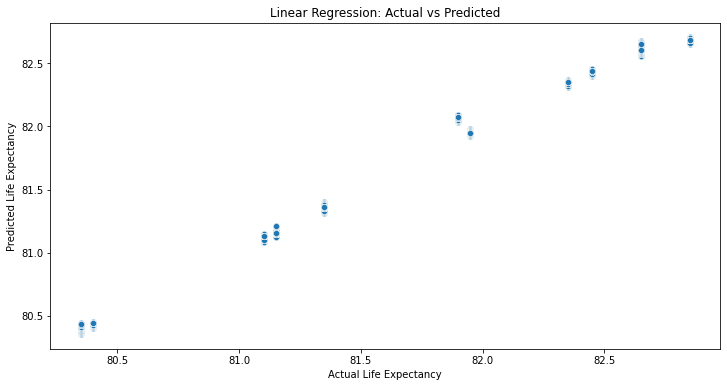

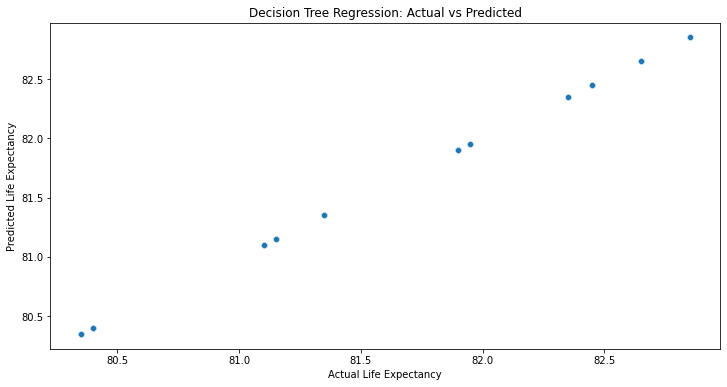

In [10]:
# Import necessary libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, avg
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline
from pyspark.ml.regression import LinearRegression, DecisionTreeRegressor
from pyspark.ml.evaluation import RegressionEvaluator
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Initialize Spark session
spark = SparkSession.builder.appName("FeatureExtractionSelection").getOrCreate()

hospital1 = spark.read.format("csv").option("header", "true").option("inferSchema", "true").load("1hospital.csv")
clients1 = spark.read.format("csv").option("header", "true").option("inferSchema", "true").load("1clients.csv")
education1 = spark.read.format("csv").option("header", "true").option("inferSchema", "true").load("1Education.csv")
income1 = spark.read.format("csv").option("header", "true").option("inferSchema", "true").load("1Income.csv")
life1 = spark.read.format("csv").option("header", "true").option("inferSchema", "true").load("life expectancy.csv")
# Merge life expectancy data with income data on 'Region'
merged_data = life.join(income1, on='Region', how='inner')

# Merge the result with education data
merged_data = merged_data.join(education1, on='Region', how='inner')

# Continue merging with clients data
merged_data = merged_data.join(clients1, on='Region', how='inner')

# Finally, merge with hospital data
final_data = merged_data.join(hospital1, on='Region', how='inner')

# Drop the columns causing issues
columns_to_drop = ['Year']
final_data = final_data.drop(*columns_to_drop)

# Handle missing values by filling with mean for numeric columns
numeric_cols = [field for (field, dataType) in final_data.dtypes if dataType in ["int", "double"]]
for col_name in numeric_cols:
    mean_value = final_data.select(avg(col_name)).first()[0]
    final_data = final_data.na.fill({col_name: mean_value})
    

# Encode categorical variables
categorical_cols = [field for (field, dataType) in final_data.dtypes if dataType == "string"]
indexers = [StringIndexer(inputCol=col, outputCol=col + "_indexed", handleInvalid="skip") for col in categorical_cols]
encoders = [OneHotEncoder(inputCol=indexer.getOutputCol(), outputCol=indexer.getOutputCol() + "_encoded") for indexer in indexers]

# Assemble features into a single vector
assembler = VectorAssembler(inputCols=[col + "_indexed_encoded" if col in categorical_cols else col for col in final_data.columns if col != "Average"], outputCol="features")

# Define the stages of the pipeline
stages = indexers + encoders + [assembler]
pipeline = Pipeline(stages=stages)

# Fit and transform the data using the pipeline
pipeline_model = pipeline.fit(final_data)
data_prepared = pipeline_model.transform(final_data)

# Split the data into train and test sets
train_data, test_data = data_prepared.randomSplit([0.8, 0.2], seed=42)

# Linear Regression Model with regularization
lr = LinearRegression(labelCol="Average", featuresCol="features", regParam=0.1)  # Set a non-zero regParam
lr_model = lr.fit(train_data)
predictions_lr = lr_model.transform(test_data)

# Decision Tree Regression
dt = DecisionTreeRegressor(labelCol="Average", featuresCol="features", maxDepth=5)
dt_model = dt.fit(train_data)
predictions_dt = dt_model.transform(test_data)

# Evaluate the models
evaluator = RegressionEvaluator(labelCol="Average", predictionCol="prediction", metricName="rmse")
rmse_lr = evaluator.evaluate(predictions_lr)
rmse_dt = evaluator.evaluate(predictions_dt)

evaluator_r2 = RegressionEvaluator(labelCol="Average", predictionCol="prediction", metricName="r2")
r2_lr = evaluator_r2.evaluate(predictions_lr)
r2_dt = evaluator_r2.evaluate(predictions_dt)

# Print model performance
print(f"Linear Regression RMSE: {rmse_lr}")
print(f"Linear Regression R2: {r2_lr}")
print(f"Decision Tree Regression RMSE: {rmse_dt}")
print(f"Decision Tree Regression R2: {r2_dt}")

# Feature Importance from Decision Tree
importances = dt_model.featureImportances
importance_dict = {col: importances[idx] for idx, col in enumerate(assembler.getInputCols())}
sorted_importance = sorted(importance_dict.items(), key=lambda x: x[1], reverse=True)

# Display the most important features
important_features = pd.DataFrame(sorted_importance, columns=['Feature', 'Importance']).head(10)
print("Most important features from Decision Tree:")
print(important_features)

# Visualization of Model Predictions
# Collect predictions and actuals to a Pandas DataFrame for plotting
predictions_lr_pd = predictions_lr.select("Average", "prediction").toPandas()
predictions_dt_pd = predictions_dt.select("Average", "prediction").toPandas()

plt.figure(figsize=(12, 6))
sns.scatterplot(x=predictions_lr_pd["Average"], y=predictions_lr_pd["prediction"])
plt.title('Linear Regression: Actual vs Predicted')
plt.xlabel('Actual Life Expectancy')
plt.ylabel('Predicted Life Expectancy')
plt.show()

plt.figure(figsize=(12, 6))
sns.scatterplot(x=predictions_dt_pd["Average"], y=predictions_dt_pd["prediction"])
plt.title('Decision Tree Regression: Actual vs Predicted')
plt.xlabel('Actual Life Expectancy')
plt.ylabel('Predicted Life Expectancy')
plt.show()




6.3

In [12]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, avg
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit

# Initialize Spark session
spark = SparkSession.builder.appName("ModelSelection").getOrCreate()

# Handle missing values by filling with mean for numeric columns
numeric_cols = [field for (field, dataType) in final_merged_data.dtypes if dataType in ["int", "double"]]
for col_name in numeric_cols:
    mean_value = final_merged_data.select(avg(col_name)).first()[0]
    final_merged_data = final_merged_data.na.fill({col_name: mean_value})

# Encode categorical variables
categorical_cols = [field for (field, dataType) in final_merged_data.dtypes if dataType == "string"]
indexers = [StringIndexer(inputCol=col, outputCol=col + "_indexed", handleInvalid="skip") for col in categorical_cols]
encoders = [OneHotEncoder(inputCol=indexer.getOutputCol(), outputCol=indexer.getOutputCol() + "_encoded") for indexer in indexers]

# Assemble features into a single vector
assembler = VectorAssembler(inputCols=[col + "_indexed_encoded" if col in categorical_cols else col for col in final_merged_data.columns if col != "Median_Income"], outputCol="features")

# Define the stages of the pipeline
stages = indexers + encoders + [assembler]
pipeline = Pipeline(stages=stages)

# Fit and transform the data using the pipeline
pipeline_model = pipeline.fit(final_merged_data)
data_prepared = pipeline_model.transform(final_merged_data)

# Initialize the Decision Tree Regressor
tree = DecisionTreeRegressor(labelCol="Median_Income", featuresCol="features")

# Define the parameter grid to search over
paramGrid = (ParamGridBuilder()
             .addGrid(tree.maxDepth, [5, 10, 20]) 
             .addGrid(tree.minInstancesPerNode, [1, 4])
             .addGrid(tree.minInfoGain, [0.0, 0.1, 0.2])
             .build())

# Initialize TrainValidationSplit
tvs = TrainValidationSplit(estimator=tree,
                           estimatorParamMaps=paramGrid,
                           evaluator=RegressionEvaluator(labelCol="Median_Income", predictionCol="prediction", metricName="rmse"),
                           trainRatio=0.8)

# Perform grid search
tvs_model = tvs.fit(data_prepared)

# Get the best model
best_tree_model = tvs_model.bestModel

# Predict using the best model
predictions = best_tree_model.transform(data_prepared)

# Evaluate the best model
evaluator = RegressionEvaluator(labelCol="Median_Income", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print(f"Best Decision Tree Model RMSE: {rmse}")

# Display the best parameters found by the grid search
print("Best parameters found:")
print(f"Max Depth: {best_tree_model.getOrDefault('maxDepth')}")
print(f"Min Instances Per Node: {best_tree_model.getOrDefault('minInstancesPerNode')}")
print(f"Min Info Gain: {best_tree_model.getOrDefault('minInfoGain')}")



24/05/23 04:03:25 WARN DecisionTreeMetadata: DecisionTree reducing maxBins from 32 to 4 (= number of training instances)
24/05/23 04:03:26 WARN DecisionTreeMetadata: DecisionTree reducing maxBins from 32 to 4 (= number of training instances)
24/05/23 04:03:27 WARN DecisionTreeMetadata: DecisionTree reducing maxBins from 32 to 4 (= number of training instances)
24/05/23 04:03:27 WARN DecisionTreeMetadata: DecisionTree reducing maxBins from 32 to 4 (= number of training instances)
24/05/23 04:03:28 WARN DecisionTreeMetadata: DecisionTree reducing maxBins from 32 to 4 (= number of training instances)
24/05/23 04:03:28 WARN DecisionTreeMetadata: DecisionTree reducing maxBins from 32 to 4 (= number of training instances)
24/05/23 04:03:29 WARN DecisionTreeMetadata: DecisionTree reducing maxBins from 32 to 4 (= number of training instances)
24/05/23 04:03:29 WARN DecisionTreeMetadata: DecisionTree reducing maxBins from 32 to 4 (= number of training instances)
24/05/23 04:03:30 WARN DecisionT

Best Decision Tree Model RMSE: 8099.382692526635
Best parameters found:
Max Depth: 5
Min Instances Per Node: 4
Min Info Gain: 0.0


7.1 Create and justify test designs

In [11]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit

# Initialize Spark session
spark = SparkSession.builder.appName("TestDesigns").getOrCreate()

# Handle missing values by filling with mean for numeric columns
numeric_cols = [field for (field, dataType) in final_data.dtypes if dataType in ["int", "double"]]
for col_name in numeric_cols:
    mean_value = final_data.select(avg(col_name)).first()[0]
    final_data = final_data.na.fill({col_name: mean_value})

# Encode categorical variables
categorical_cols = [field for (field, dataType) in final_data.dtypes if dataType == "string"]
indexers = [StringIndexer(inputCol=col, outputCol=col + "_indexed", handleInvalid="skip") for col in categorical_cols]
encoders = [OneHotEncoder(inputCol=indexer.getOutputCol(), outputCol=indexer.getOutputCol() + "_encoded") for indexer in indexers]

# Remove the existing 'features' column if it exists
if 'features' in final_data.columns:
    final_data = final_data.drop('features')

# Assemble features into a single vector
assembler = VectorAssembler(inputCols=[col + "_indexed_encoded" if col in categorical_cols else col for col in final_data.columns if col != "Average"], outputCol="features")

# Define the stages of the pipeline
stages = indexers + encoders + [assembler]
pipeline = Pipeline(stages=stages)

# Fit and transform the data using the pipeline
pipeline_model = pipeline.fit(final_data)
data_prepared = pipeline_model.transform(final_data)

# Split the data into train and test sets
train_data, test_data = data_prepared.randomSplit([0.8, 0.2], seed=42)

# Print the sizes of the training and test sets to verify the split
print(f"Training set size: {train_data.count()} samples")
print(f"Testing set size: {test_data.count()} samples")


Training set size: 261595 samples


Testing set size: 65465 samples


7.2

In [12]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit


# Initialize the Decision Tree Regressor
tree = DecisionTreeRegressor(labelCol="Average", featuresCol="features")

# Define the parameter grid to search over
paramGrid = (ParamGridBuilder()
             .addGrid(tree.maxDepth, [5, 10, 20])
             .addGrid(tree.minInstancesPerNode, [1, 4])
             .addGrid(tree.minInfoGain, [0.0, 0.1, 0.2])
             .build())

# Initialize TrainValidationSplit
tvs = TrainValidationSplit(estimator=tree,
                           estimatorParamMaps=paramGrid,
                           evaluator=RegressionEvaluator(labelCol="Average", predictionCol="prediction", metricName="rmse"),
                           trainRatio=0.8)

# Perform grid search
tvs_model = tvs.fit(train_data)

# Get the best model
best_tree_model = tvs_model.bestModel

# Predict on training data
train_predictions = best_tree_model.transform(train_data)

# Predict on testing data
test_predictions = best_tree_model.transform(test_data)

# Evaluate the model on training data
train_evaluator = RegressionEvaluator(labelCol="Average", predictionCol="prediction", metricName="rmse")
train_rmse = train_evaluator.evaluate(train_predictions)
print(f"Training Data RMSE: {train_rmse}")

# Evaluate the model on testing data
test_evaluator = RegressionEvaluator(labelCol="Average", predictionCol="prediction", metricName="rmse")
test_rmse = test_evaluator.evaluate(test_predictions)
print(f"Testing Data RMSE: {test_rmse}")

# Calculate R-squared for both training and testing sets
r2_evaluator = RegressionEvaluator(labelCol="Average", predictionCol="prediction", metricName="r2")
r2_train = r2_evaluator.evaluate(train_predictions)
r2_test = r2_evaluator.evaluate(test_predictions)
print(f"Training Data R2: {r2_train}")
print(f"Testing Data R2: {r2_test}")



24/05/23 05:53:13 WARN MemoryStore: Not enough space to cache rdd_2507_0 in memory! (computed 115.9 MiB so far)
24/05/23 05:53:13 WARN BlockManager: Persisting block rdd_2507_0 to disk instead.


Training Data RMSE: 3.8301679649351986e-11


Testing Data RMSE: 3.830508916708144e-11


Training Data R2: 1.0
Testing Data R2: 1.0


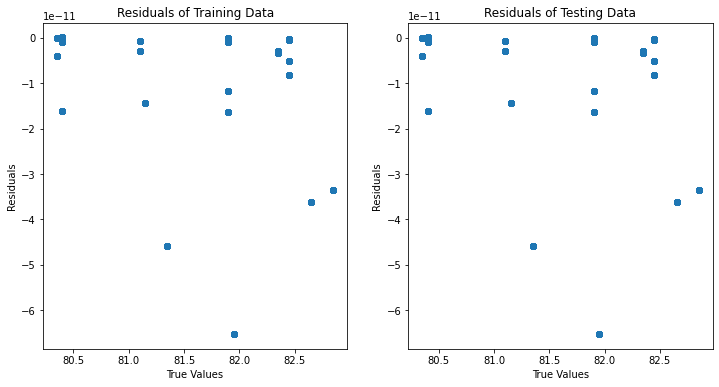

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
# Plot residuals
# Extract true and predicted values
train_y_true = train_predictions.select("Average").rdd.flatMap(lambda x: x).collect()
train_y_pred = train_predictions.select("prediction").rdd.flatMap(lambda x: x).collect()
test_y_true = test_predictions.select("Average").rdd.flatMap(lambda x: x).collect()
test_y_pred = test_predictions.select("prediction").rdd.flatMap(lambda x: x).collect()

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(train_y_true, [y_true - y_pred for y_true, y_pred in zip(train_y_true, train_y_pred)])
plt.title('Residuals of Training Data')
plt.xlabel('True Values')
plt.ylabel('Residuals')

plt.subplot(1, 2, 2)
plt.scatter(test_y_true, [y_true - y_pred for y_true, y_pred in zip(test_y_true, test_y_pred)])
plt.title('Residuals of Testing Data')
plt.xlabel('True Values')
plt.ylabel('Residuals')
plt.show()



8.2 Visualize the data, results, models, and patterns

24/05/23 06:35:01 WARN MemoryStore: Not enough space to cache rdd_6794_0 in memory! (computed 115.9 MiB so far)
24/05/23 06:35:01 WARN BlockManager: Persisting block rdd_6794_0 to disk instead.


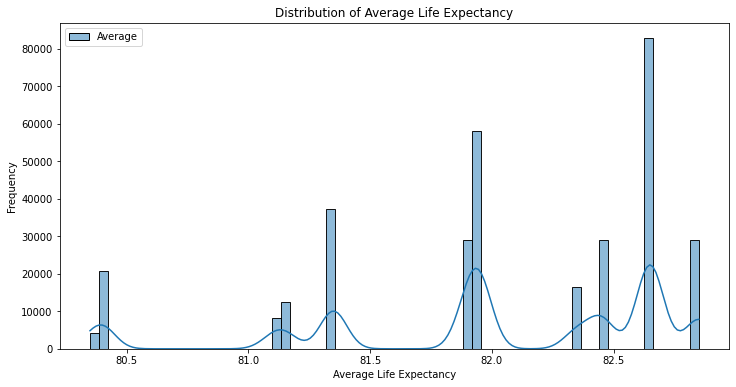

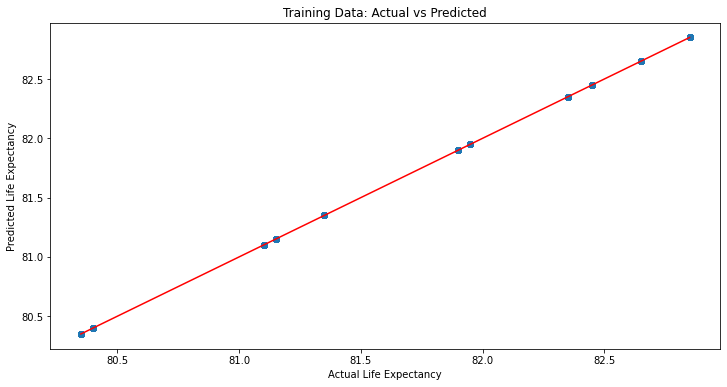

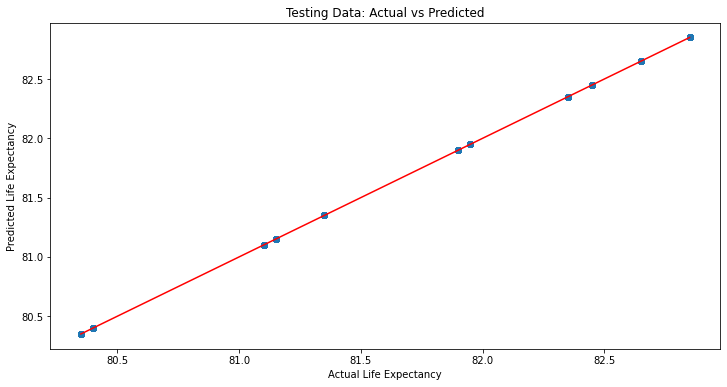

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, avg
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit

# Initialize Spark session
spark = SparkSession.builder.appName("Visualization").getOrCreate()

# Load and prepare the data (assuming final_data is already loaded)
# Handle missing values by filling with mean for numeric columns
numeric_cols = [field for (field, dataType) in final_data.dtypes if dataType in ["int", "double"]]
for col_name in numeric_cols:
    mean_value = final_data.select(avg(col_name)).first()[0]
    final_data = final_data.na.fill({col_name: mean_value})

# Encode categorical variables
categorical_cols = [field for (field, dataType) in final_data.dtypes if dataType == "string"]
indexers = [StringIndexer(inputCol=col, outputCol=col + "_indexed", handleInvalid="skip") for col in categorical_cols]
encoders = [OneHotEncoder(inputCol=indexer.getOutputCol(), outputCol=indexer.getOutputCol() + "_encoded") for indexer in indexers]

# Assemble features into a single vector
assembler = VectorAssembler(inputCols=[col + "_indexed_encoded" if col in categorical_cols else col for col in final_data.columns if col != "Average"], outputCol="features")

# Define the stages of the pipeline
stages = indexers + encoders + [assembler]
pipeline = Pipeline(stages=stages)

# Fit and transform the data using the pipeline
pipeline_model = pipeline.fit(final_data)
data_prepared = pipeline_model.transform(final_data)

# Split the data into train and test sets
train_data, test_data = data_prepared.randomSplit([0.8, 0.2], seed=42)

# Initialize the Decision Tree Regressor
tree = DecisionTreeRegressor(labelCol="Average", featuresCol="features")

# Define the parameter grid to search over
paramGrid = (ParamGridBuilder()
             .addGrid(tree.maxDepth, [5, 10, 20])
             .addGrid(tree.minInstancesPerNode, [1, 4])
             .addGrid(tree.minInfoGain, [0.0, 0.1, 0.2])
             .build())

# Initialize TrainValidationSplit
tvs = TrainValidationSplit(estimator=tree,
                           estimatorParamMaps=paramGrid,
                           evaluator=RegressionEvaluator(labelCol="Average", predictionCol="prediction", metricName="rmse"),
                           trainRatio=0.8)

# Perform grid search
tvs_model = tvs.fit(train_data)

# Get the best model
best_tree_model = tvs_model.bestModel

# Predict using the best model
train_predictions = best_tree_model.transform(train_data)
test_predictions = best_tree_model.transform(test_data)

# Extract true and predicted values
train_y_true = train_predictions.select("Average").toPandas()
train_y_pred = train_predictions.select("prediction").toPandas()
test_y_true = test_predictions.select("Average").toPandas()
test_y_pred = test_predictions.select("prediction").toPandas()

# Visualize the distribution of the target variable
plt.figure(figsize=(12, 6))
sns.histplot(final_data.select("Average").toPandas(), kde=True)
plt.title("Distribution of Average Life Expectancy")
plt.xlabel("Average Life Expectancy")
plt.ylabel("Frequency")
plt.show()

# Visualize actual vs predicted values for training data
plt.figure(figsize=(12, 6))
plt.scatter(train_y_true, train_y_pred)
plt.title("Training Data: Actual vs Predicted")
plt.xlabel("Actual Life Expectancy")
plt.ylabel("Predicted Life Expectancy")
plt.plot([min(train_y_true.values), max(train_y_true.values)], [min(train_y_true.values), max(train_y_true.values)], color='red')
plt.show()

# Visualize actual vs predicted values for testing data
plt.figure(figsize=(12, 6))
plt.scatter(test_y_true, test_y_pred)
plt.title("Testing Data: Actual vs Predicted")
plt.xlabel("Actual Life Expectancy")
plt.ylabel("Predicted Life Expectancy")
plt.plot([min(test_y_true.values), max(test_y_true.values)], [min(test_y_true.values), max(test_y_true.values)], color='red')
plt.show()




In [30]:
hospital1 = spark.read.format("csv").option("header", "true").option("inferSchema", "true").load("1hospital.csv")
clients1 = spark.read.format("csv").option("header", "true").option("inferSchema", "true").load("1clients.csv")
education1 = spark.read.format("csv").option("header", "true").option("inferSchema", "true").load("1Education.csv")
income1 = spark.read.format("csv").option("header", "true").option("inferSchema", "true").load("1Income.csv")
life1 = spark.read.format("csv").option("header", "true").option("inferSchema", "true").load("life expectancy.csv")
# Merge life expectancy data with income data on 'Region'
merged_data = life.join(income1, on='Region', how='inner')

# Merge the result with education data
merged_data = merged_data.join(education1, on='Region', how='inner')

# Continue merging with clients data
merged_data = merged_data.join(clients1, on='Region', how='inner')

# Finally, merge with hospital data
final_data = merged_data.join(hospital1, on='Region', how='inner')

# Show the first few rows of the merged dataset
final_data.show()

# Drop the columns causing issues
columns_to_drop = ['Region', 'destination', 'Premises_Name', 'Year']
final_data = final_data.drop(*columns_to_drop)


+---------+----+------+-------+----+------------------------------+------------------------------+----------------------------------+-----------------------------------------+-----------------------------+----------------------------------------+-----+-------------------------------+---------------------------------------------------------+--------------------------------------------------+-----------+------+----+--------------------+----------+--------+
|   Region|Male|Female|Average|Year|Average Wage and Salary Income|Average Self-employment Income|Average Government Transfer Income|Average Income from All Sources collected|Median Wage and Salary Income|Median Income from All Sources collected|Years|Below upper secondary education|Upper secondary and post-secondary non-tertiary education|Total tertiary education (ISCED2011 levels 5 to 8)|destination|amount|year|       Premises_Name|Total_Beds|ObjectId|
+---------+----+------+-------+----+------------------------------+---------------

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit


Number of features: 15
Length of feature importances array: 15
Feature importances:
 Female                                                       9.726656e-01
Male                                                         2.667661e-02
Total tertiary education (ISCED2011 levels 5 to 8)           6.577541e-04
Upper secondary and post-secondary non-tertiary education    1.492145e-09
Average Wage and Salary Income                               2.017239e-10
Average Income from All Sources collected                    5.031437e-11
Total_Beds                                                   2.390370e-12
ObjectId                                                     1.282638e-12
Average Self-employment Income                               0.000000e+00
Average Government Transfer Income                           0.000000e+00
dtype: float64


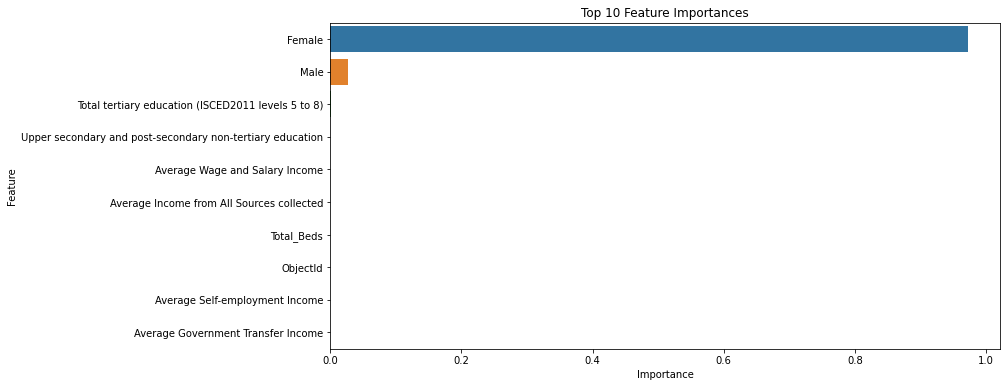

In [33]:

numeric_cols = [field for (field, dataType) in final_data.dtypes if dataType in ["int", "double"]]
for col_name in numeric_cols:
    mean_value = final_data.select(avg(col_name)).first()[0]
    final_data = final_data.na.fill({col_name: mean_value})


assembler = VectorAssembler(inputCols=[col for col in numeric_cols if col != "Average"], outputCol="features")

data_prepared = assembler.transform(final_data)


train_data, test_data = data_prepared.randomSplit([0.8, 0.2], seed=42)

tree = DecisionTreeRegressor(labelCol="Average", featuresCol="features")

paramGrid = (ParamGridBuilder()
             .addGrid(tree.maxDepth, [5, 10, 20])
             .addGrid(tree.minInstancesPerNode, [1, 4])
             .addGrid(tree.minInfoGain, [0.0, 0.1, 0.2])
             .build())

tvs = TrainValidationSplit(estimator=tree,
                           estimatorParamMaps=paramGrid,
                           evaluator=RegressionEvaluator(labelCol="Average", predictionCol="prediction", metricName="rmse"),
                           trainRatio=0.8)

tvs_model = tvs.fit(train_data)


best_tree_model = tvs_model.bestModel

train_predictions = best_tree_model.transform(train_data)
test_predictions = best_tree_model.transform(test_data)


train_y_true = train_predictions.select("Average").toPandas()
train_y_pred = train_predictions.select("prediction").toPandas()
test_y_true = test_predictions.select("Average").toPandas()
test_y_pred = test_predictions.select("prediction").toPandas()


feature_names = [col for col in numeric_cols if col != "Average"]
print(f"Number of features: {len(feature_names)}")
print(f"Length of feature importances array: {len(best_tree_model.featureImportances.toArray())}")

importance = pd.Series(best_tree_model.featureImportances.toArray(), index=feature_names).sort_values(ascending=False)
print("Feature importances:\n", importance.head(10))


plt.figure(figsize=(12, 6))
sns.barplot(x=importance.head(10), y=importance.head(10).index)
plt.title("Top 10 Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

8.5

Training Data RMSE: 3.806790076006301e-11
Testing Data RMSE: 3.808762233166079e-11


Training Data R2: 1.0
Testing Data R2: 1.0
Feature importances:
 Female                                                       9.726656e-01
Male                                                         2.667661e-02
Total tertiary education (ISCED2011 levels 5 to 8)           6.577541e-04
Upper secondary and post-secondary non-tertiary education    1.492145e-09
Average Wage and Salary Income                               2.017239e-10
Average Income from All Sources collected                    5.031437e-11
Total_Beds                                                   2.390370e-12
ObjectId                                                     1.282638e-12
Average Self-employment Income                               0.000000e+00
Average Government Transfer Income                           0.000000e+00
dtype: float64


<function matplotlib.pyplot.xlabel(xlabel, fontdict=None, labelpad=None, *, loc=None, **kwargs)>

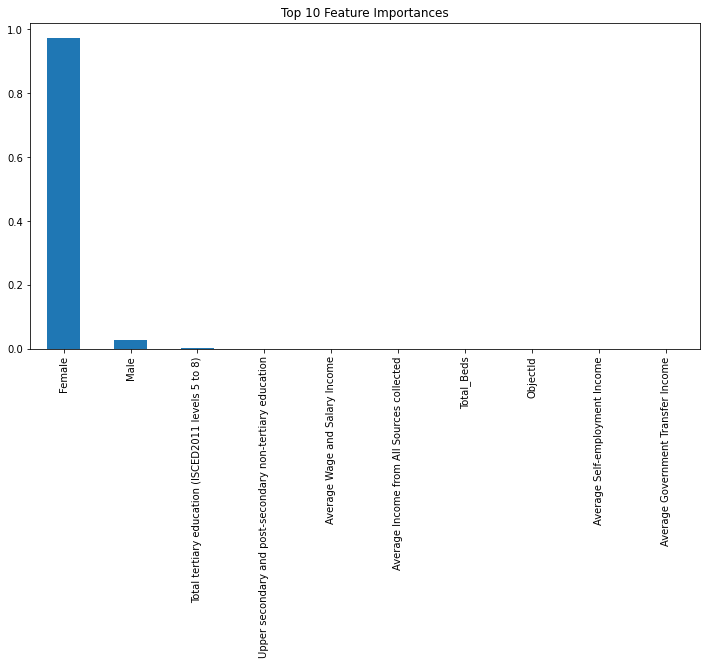

In [39]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit

# Initialize Spark session
spark = SparkSession.builder.appName("IterativeModelSelection").getOrCreate()

# Handle missing values by filling with mean for numeric columns
numeric_cols = [field for (field, dataType) in final_data.dtypes if dataType in ["int", "double"]]
for col_name in numeric_cols:
    mean_value = final_data.select(avg(col_name)).first()[0]
    final_data = final_data.na.fill({col_name: mean_value})

# Remove the existing 'features' column if it exists
if 'features' in final_data.columns:
    final_data = final_data.drop('features')

# Assemble features into a single vector
assembler = VectorAssembler(inputCols=[col for col in final_data.columns if col != "Average"], outputCol="features")

# Transform the data using the assembler
data_prepared = assembler.transform(final_data)

# Split the data into train and test sets
train_data, test_data = data_prepared.randomSplit([0.8, 0.2], seed=42)

# Initialize the Decision Tree Regressor
tree = DecisionTreeRegressor(labelCol="Average", featuresCol="features")

# Define the parameter grid to search over
paramGrid = (ParamGridBuilder()
             .addGrid(tree.maxDepth, [5, 10, 20])
             .addGrid(tree.minInstancesPerNode, [2, 5, 10])
             .build())

# Initialize TrainValidationSplit
tvs = TrainValidationSplit(estimator=tree,
                           estimatorParamMaps=paramGrid,
                           evaluator=RegressionEvaluator(labelCol="Average", predictionCol="prediction", metricName="rmse"),
                           trainRatio=0.8)

# Perform grid search
tvs_model = tvs.fit(train_data)

# Get the best model
best_tree_model = tvs_model.bestModel

# Predict using the best model
train_predictions = best_tree_model.transform(train_data)
test_predictions = best_tree_model.transform(test_data)

# Evaluate the best model
evaluator = RegressionEvaluator(labelCol="Average", predictionCol="prediction", metricName="rmse")
rmse_train = evaluator.evaluate(train_predictions)
rmse_test = evaluator.evaluate(test_predictions)
print(f"Training Data RMSE: {rmse_train}")
print(f"Testing Data RMSE: {rmse_test}")

# Calculate R-squared for both training and testing sets
r2_evaluator = RegressionEvaluator(labelCol="Average", predictionCol="prediction", metricName="r2")
r2_train = r2_evaluator.evaluate(train_predictions)
r2_test = r2_evaluator.evaluate(test_predictions)
print(f"Training Data R2: {r2_train}")
print(f"Testing Data R2: {r2_test}")


# Display feature importance for Decision Tree or any tree-based model
importance = pd.Series(best_tree_model.featureImportances.toArray(), index=assembler.getInputCols()).sort_values(ascending=False)
print("Feature importances:\n", importance.head(10))

# Visualize feature importance
plt.figure(figsize=(12, 6))
importance.head(10).plot(kind='bar')
plt.title('Top 10 Feature Importances')
plt.xlabel
